In [1]:
import pandas as pd
import requests
import json
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from s2_key import *

# Collect and process references

In [ ]:
prefiltered_papers_df = pd.read_csv('annotated-excerpts.csv')
filtered_papers_df = prefiltered_papers_df[prefiltered_papers_df['1 = Relevant / 0 = Irrelevant'] == 1]
filtered_papers_df = filtered_papers_df[filtered_papers_df['1 = Reference'] != 1]
filtered_papers = set(filtered_papers_df['Corpus ID'])

In [ ]:
data = {}

for idx, corpusId in enumerate(filtered_papers):
    if idx % 20 == 0:
        print(idx)
    
    ref_data = requests.get(
        'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}/references'.format(corpusId),
        params={'fields': 'contextsWithIntent,corpusId,venue,title,fieldsOfStudy,s2FieldsOfStudy,citationCount,publicationTypes'},
        headers = {"Accept": "*/*", "x-api-key": S2_KEY}
    ).json()

    if 'data' in ref_data:
        data[corpusId] = ref_data['data']
    
        while 'next' in ref_data:
            ref_data = requests.get(
                'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}/references'.format(corpusId),
                params={'fields': 'contextsWithIntent,corpusId,venue,title,fieldsOfStudy,s2FieldsOfStudy,citationCount,publicationTypes', 'offset': ref_data['next']},
                headers = {"Accept": "*/*", "x-api-key": S2_KEY}
            ).json()
            data[corpusId].extend(ref_data['data'])

In [ ]:
with open('references-data.json', 'wb') as f:
    pickle.dump(data, f)

# Network analysis

In [3]:
with open('references-data.json', 'rb') as f:
    data = pickle.load(f)

## Fields of study

In [4]:
all_FOS = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            ref_FOS = set()
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                ref_FOS.add(fos['category'])
            all_FOS.extend(ref_FOS)

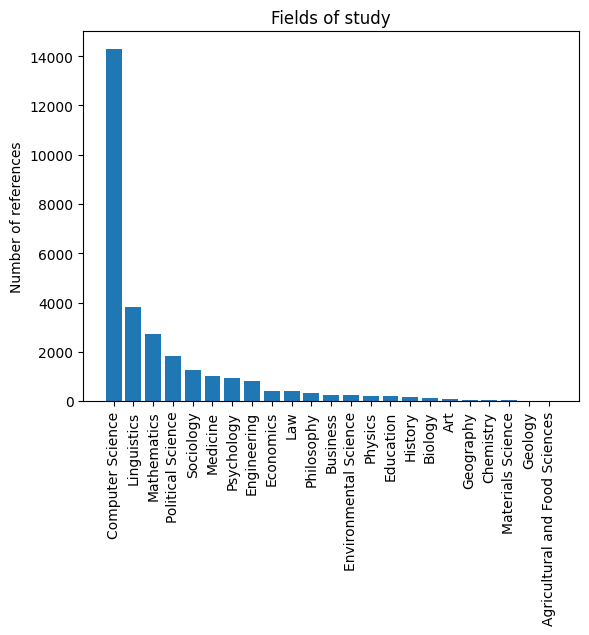

In [5]:
FOS_freqs = Counter(all_FOS)
FOS, freqs = list(zip(*FOS_freqs.most_common()))

plt.bar(FOS, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of references')
plt.title('Fields of study')
plt.show()

In [6]:
intra_FOS = set(['Computer Science', 'Linguistics', 'Mathematics', 'Engineering'])

In [7]:
prop_other_FOS = []

for corpusId, refs in data.items():
    num_other_FOS = 0
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                num_other_FOS += 1
    if len(refs) > 0:
        prop_other_FOS.append(num_other_FOS / len(refs))

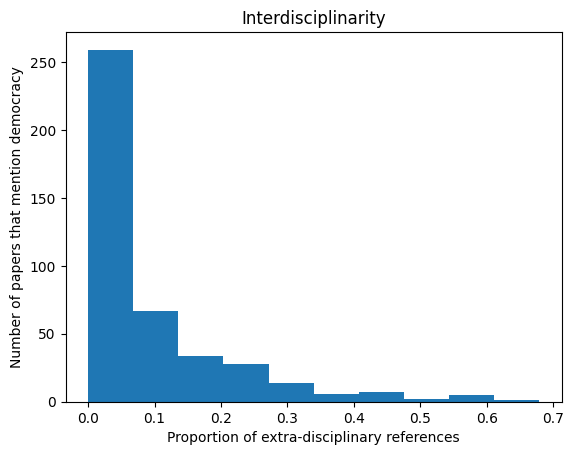

In [8]:
plt.hist(prop_other_FOS)
plt.ylabel('Number of papers that mention democracy')
plt.xlabel('Proportion of extra-disciplinary references')
plt.title('Interdisciplinarity')
plt.show()

## Intents

In [9]:
all_intents = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                ref_intents = set()
                for context in ref['contextsWithIntent']:
                    ref_intents.update(set(context['intents']))
                all_intents.extend(list(ref_intents))

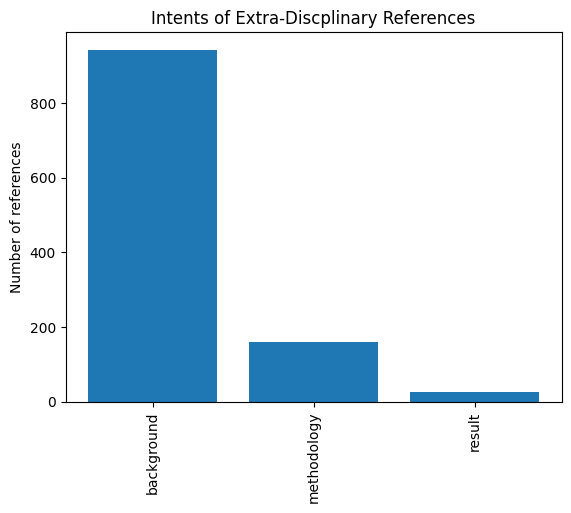

In [10]:
intents_freqs = Counter(all_intents)
intents, freqs = list(zip(*intents_freqs.most_common()))

plt.bar(intents, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of references')
plt.title('Intents of Extra-Discplinary References')
plt.show()

## Venues

In [11]:
all_venues = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            if len(ref['citedPaper']['venue']) > 0:
                all_venues.append(ref['citedPaper']['venue'])

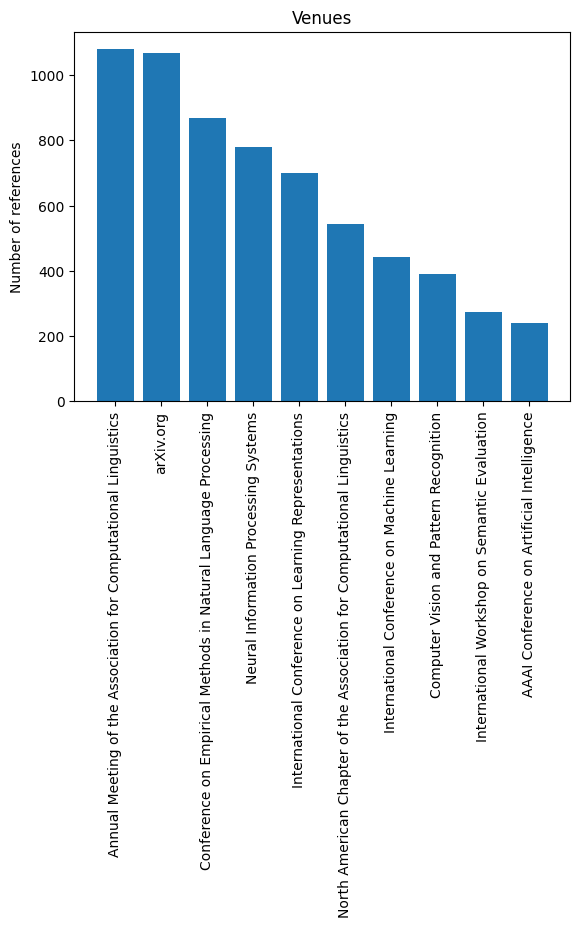

In [12]:
venue_freqs = Counter(all_venues)
venues, freqs = list(zip(*venue_freqs.most_common(10)))

plt.bar(venues, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of references')
plt.title('Venues')
plt.show()

In [13]:
all_extra_venues = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                if len(ref['citedPaper']['venue']) > 0:
                    all_extra_venues.append(ref['citedPaper']['venue'])

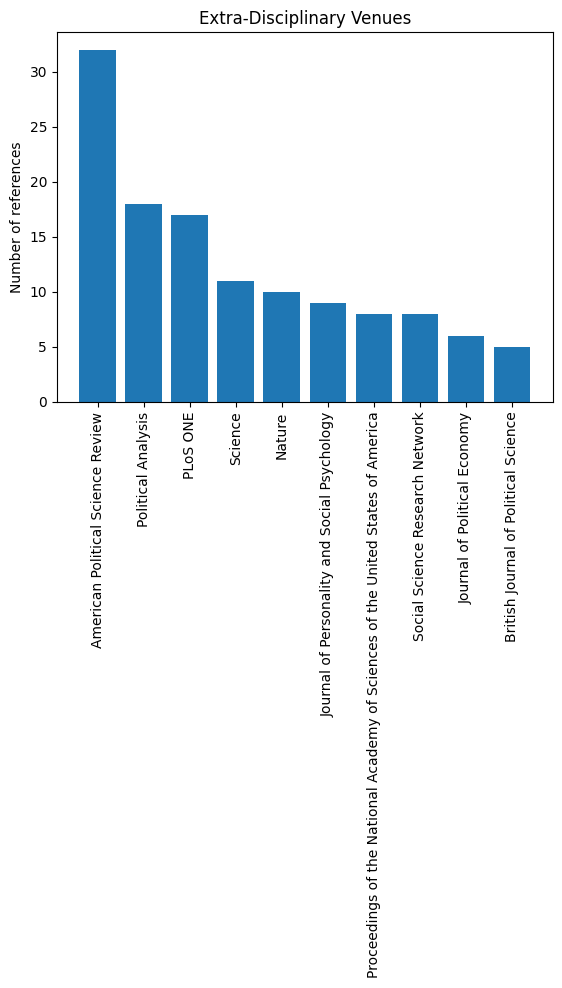

In [14]:
venue_freqs = Counter(all_extra_venues)
venues, freqs = list(zip(*venue_freqs.most_common(10)))

plt.bar(venues, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of references')
plt.title('Extra-Disciplinary Venues')
plt.show()

## Most Cited

In [15]:
all_titles = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                if len(ref['citedPaper']['title']) > 0:
                    all_titles.append(ref['citedPaper']['title'])

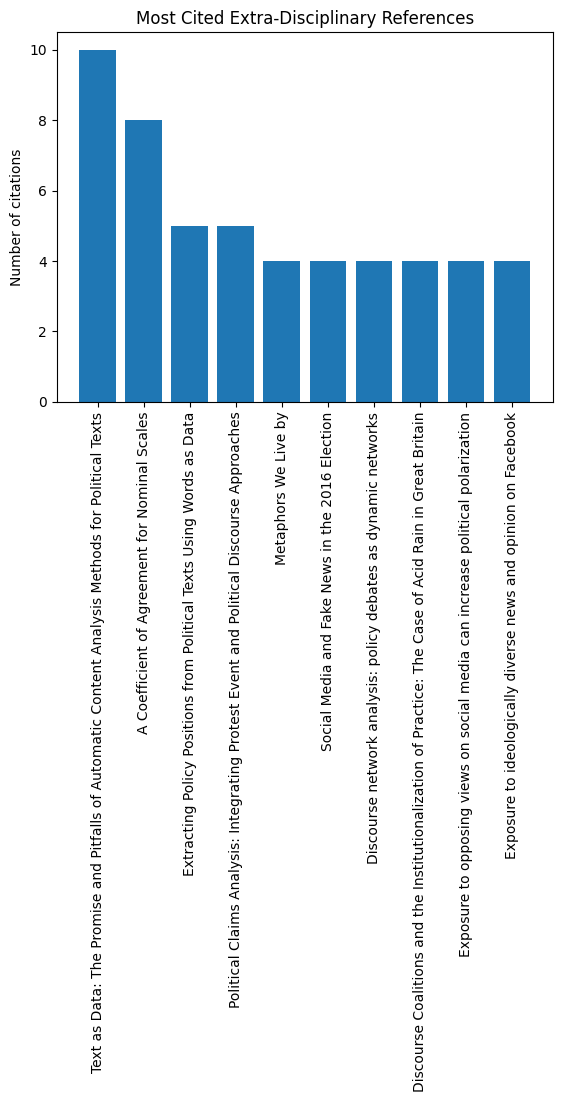

In [16]:
title_freqs = Counter(all_titles)
titles, freqs = list(zip(*title_freqs.most_common(10)))

plt.bar(titles, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of citations')
plt.title('Most Cited Extra-Disciplinary References')
plt.show()